## First try

In [1]:
# !pip install torch torchvision scikit-learn matplotlib numpy

In [ ]:
# imports 
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import numpy as np
import copy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
# define the device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [4]:
# seeding for reproducibility 

torch.manual_seed(10)

#### Handle input

Everything in this section does not change

In [5]:
# define directory
data_dir = "./data"

# transform to convert input into pytorch tensor
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

# train and test data 
train_dataset = datasets.ImageFolder(root = os.path.join(data_dir, "train"), transform = transform)
test_dataset  = datasets.ImageFolder(root = os.path.join(data_dir, "test"), transform = transform)

# data loader objects for batch processing during training
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader  = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [6]:
# define input dims and num classes, global + constants
input_dim = 224 * 224 * 3
num_classes = len(train_dataset.classes)

# criterion stays the same (cross entropy) because its multiclass classification
criterion = nn.CrossEntropyLoss()

#### Defining some functions

Helper functions to call

In [7]:
def train_model_early(NN, optimizer_class, lr_, criterion, train_loader, test_loader, weight_decay = 0.0, num_epochs = 100, patience=10, min_delta=0.0001):

    """
    Trains a neural network with early stopping based on test loss.

    Args:
        NN (callable): A callable that returns an instance of the neural network model.
        optimizer_class (torch.optim.Optimizer): Optimizer class to use for training.
        lr_ (float): Learning rate for the optimizer.
        criterion (callable): Loss function used for training and evaluation.
        train_loader (DataLoader): DataLoader providing the training data batches.
        test_loader (DataLoader): DataLoader providing the testing/validation data batches.
        weight_decay (float, optional): L2 regularization factor. Defaults to 0.0.
        num_epochs (int, optional): Maximum number of training epochs. Defaults to 100.
        patience (int, optional): Number of epochs without improvement in test loss before early stopping. Defaults to 10.
        min_delta (float, optional): Minimum change in test loss to qualify as an improvement. Defaults to 0.0001.

    Returns:
        model (torch.nn.Module): The trained model with the best-performing weights restored.
        train_losses (list of float): Recorded training batch losses for each epoch.
        test_losses (list of float): Recorded average test losses for each epoch.
    """
    
    # early stopping tracking variables
    best_test_loss = float('inf')
    best_model_wts = None
    epochs_no_improve = 0

    # initialize model and optimizer
    model = NN().to(device)
    optimizer = optimizer_class(model.parameters(), lr = lr_, weight_decay = weight_decay)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(num_epochs):
        # training
        model.train()

        # use minibacthes
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # backward and optimize (for one batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        

        train_losses.append(loss.item())
    
        # testing
        model.eval()
        
        total_test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                test_outputs = model(X_batch)
                total_test_loss += criterion(test_outputs, y_batch).item()
        
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        
    
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Batch Loss: {loss.item():.4f}, Test Avg Loss: {avg_test_loss:.4f}")

        # early stopping
        if avg_test_loss < best_test_loss - min_delta:
            # improvement found
            best_test_loss = avg_test_loss
            epochs_no_improve = 0
            
            # save the current best weights
            best_model_wts = copy.deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after {epoch + 1} epochs (Patience: {patience}). Restoring best model from test loss {best_test_loss:.4f}.")

                # load the best model weights before returning
                model.load_state_dict(best_model_wts)
                break

    return model, train_losses, test_losses

In [8]:
def plot_losses(train_losses, test_losses):

    """
    Plots the training and testing loss curves over epochs.

    Args:
        train_losses (list or array-like): Sequence of training loss values recorded per epoch.
        test_losses (list or array-like): Sequence of testing loss values recorded per epoch.

    Returns:
        None: Displays a matplotlib plot of the loss curves.
    """

    plt.figure(figsize = (8,5))
    plt.plot(train_losses, label = "Training loss")
    plt.plot(test_losses, label = "Testing loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs testing loss")
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
def get_f1(model, data_loader, set_name):

    """
    Computes and prints the macro F1 score for a given model and dataset.

    Args:
        model (torch.nn.Module): Trained neural network model used for predictions.
        data_loader (DataLoader): DataLoader providing data and labels for evaluation.
        set_name (str): Name of the dataset (e.g., "Train", "Test") for display purposes.

    Returns:
        float: The computed macro F1 score for the provided dataset.
    """
    
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            outputs = model(X_batch)
            preds = outputs.argmax(dim = 1)

            # store 
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
        
        final_preds = np.concatenate(all_preds)
        final_labels = np.concatenate(all_labels)

        f1 = f1_score(final_labels, final_preds, average = "macro")
    
    print(f"{set_name} F1: {f1:.4f}")
    return f1

#### More complex architecture

Here im adding more layers and more neurons to make the NN deeper

In [10]:
class ComplexNeuralNetwork(nn.Module):

    """
    A deep fully connected neural network with multiple linear layers, batch
    normalization, ReLU activations, and dropout regularization. Designed for
    high-capacity learning on flattened input data.

    Attributes:
        flatten (nn.Flatten): Layer that flattens the input tensor.
        linear_relu_stack (nn.Sequential): Sequential container of linear layers,
            batch normalization layers, ReLU activations, and dropout layers,
            culminating in a final linear output layer producing class logits.

    Args:
        None: Uses externally defined `input_dim` and `num_classes` to construct layers.

    Methods:
        forward(x):
            Performs a forward pass through the full network.

            Args:
                x (torch.Tensor): Input tensor.

            Returns:
                torch.Tensor: Output logits for each class.
    """

    def __init__(self):
        super().__init__()
        # flatten input
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            # Output layer
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# 
model_2 = ComplexNeuralNetwork().to(device)
print(model_2)

ComplexNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=150528, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=1024, out_features=512, bias=True)
    (9): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=512, out_features=512, bias=True)
    (13): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.3, inplace=False)
    (16): Linear(in_features=512, out_features=256, bi

#### Regularization technique: early stopping

In [35]:
# trainning model
lr_ = 0.015
model, train_losses, test_losses = train_model_early(ComplexNeuralNetwork, torch.optim.Adam, lr_, criterion, train_loader, test_loader, weight_decay = 0.0, num_epochs = 100, patience = 30, min_delta = 0.001)

Epoch [10/100], Train Batch Loss: 1.0459, Test Avg Loss: 0.9623
Epoch [20/100], Train Batch Loss: 0.7493, Test Avg Loss: 0.9053
Epoch [30/100], Train Batch Loss: 0.3656, Test Avg Loss: 1.0748
Epoch [40/100], Train Batch Loss: 2.1392, Test Avg Loss: 1.7333
Epoch [50/100], Train Batch Loss: 0.2806, Test Avg Loss: 1.3600
Epoch [60/100], Train Batch Loss: 1.6499, Test Avg Loss: 1.2274

Early stopping triggered after 67 epochs (Patience: 30). Restoring best model from test loss 0.7452.


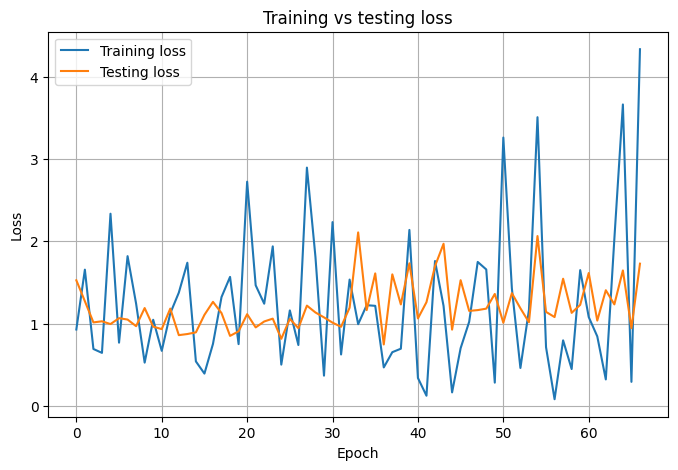

In [36]:
# plotting losses
plot_losses(train_losses, test_losses)

In [37]:
# get the train and test f1 scores
get_f1(model, train_loader, "Training set")
get_f1(model, test_loader, "Testing set set")

Training set F1: 0.9420
Testing set set F1: 0.7100


0.71

#### Confusion matrix visualization

<Figure size 600x600 with 0 Axes>

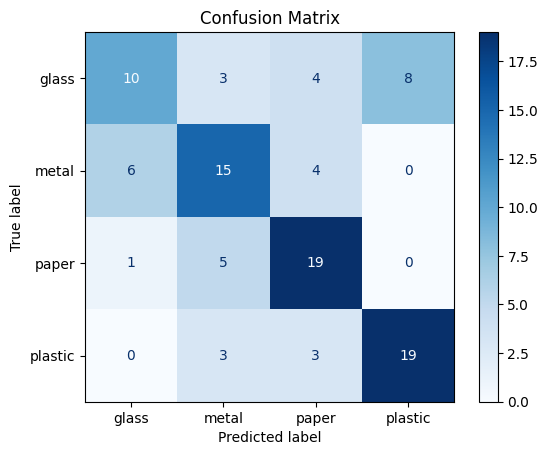

In [13]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = train_dataset.classes)

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()